In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patheffects import withStroke

from decifer_refactored.utility import (
    extract_composition,
    extract_data_formula
) 

def load_and_prepare_dataframe(pickle_path):
    # Define numeric fields of interest
    numeric_fields = [
        'rwp', 'cif_name', 'cif_string_gen', 'cif_string_sample',
        'spacegroup_gen', 'crystal_system_gen', 
        'a_gen', 'b_gen', 'c_gen', 'alpha_gen', 'beta_gen', 'gamma_gen',
        'spacegroup_sample', 'crystal_system_sample', 
        'a_sample', 'b_sample', 'c_sample', 'alpha_sample', 'beta_sample', 'gamma_sample'
    ]
    
    # Load the pickle file
    with open(pickle_path, "rb") as f:
        results = pickle.load(f)
    
    # Prepare a list to collect rows for the DataFrame
    rows = []
    
    for cif_result in results:
        # Initialize a dictionary to store field values for this CIF across all generations
        data_dict = {}
        # We'll assume each field list has the same length
        for field in numeric_fields:
            # Extract data if present
            if field in cif_result:
                # Extract and flatten out values (handling arrays)
                flat_vals = []
                for val in cif_result[field]:
                    if isinstance(val, np.ndarray):
                        # If it's a numpy array, extract its single value 
                        # (assuming one element arrays)
                        flat_vals.append(val.item())
                    else:
                        flat_vals.append(val)
                data_dict[field] = flat_vals
            else:
                data_dict[field] = []

            # Add composition
            if field == 'cif_string_gen':
                flat_comp = [extract_data_formula(cif) for cif in data_dict['cif_string_gen']]
                data_dict['composition_gen'] = flat_comp
        
        # Add row information for each generation entry
        # Assuming all fields are lists of equal length per CIF result
        num_entries = len(data_dict[numeric_fields[0]]) if numeric_fields[0] in data_dict else 0
        for i in range(num_entries):
            row = {}
            for field in numeric_fields:
                # If the list is empty, skip
                if len(data_dict[field]) > i:
                    row[field] = data_dict[field][i]
                else:
                    row[field] = None

                # Add composition
                if field == 'cif_string_gen':
                    row['composition_gen'] = data_dict['composition_gen'][i]
            rows.append(row)
    
    # Create and return a DataFrame
    return pd.DataFrame(rows)

def filter_dataframe_by_cif_name(df, cif_index):
    # Get the unique cif_name values
    unique_cif_names = df['cif_name'].dropna().unique()
    
    # Check if the provided index is valid
    if not (0 <= cif_index < len(unique_cif_names)):
        raise ValueError(f"Invalid index {cif_index}. Must be between 0 and {len(unique_cif_names) - 1}.")
    
    # Get the selected cif_name
    selected_cif_name = unique_cif_names[cif_index]
    
    # Filter the DataFrame
    filtered_df = df[df['cif_name'] == selected_cif_name]
    return filtered_df


In [2]:
INDEX = 0
df_none = load_and_prepare_dataframe("../self_consistency_none/results.pkl")
df_comp = load_and_prepare_dataframe("../self_consistency_comp/results.pkl")
df_compsg = load_and_prepare_dataframe("../self_consistency_compsg/results.pkl")
df_none = filter_dataframe_by_cif_name(df_none, INDEX)
df_comp = filter_dataframe_by_cif_name(df_comp, INDEX)
df_compsg = filter_dataframe_by_cif_name(df_compsg, INDEX)

# df_none = df_none.sample(n=5000, random_state=42)
# df_comp = df_comp.sample(n=5000, random_state=42)
# df_compsg = df_compsg.sample(n=5000, random_state=42)

# Ensure consistent length for the second plot
min_length = min(len(df_none), len(df_comp), len(df_compsg))

# Combine data for violin plot
combined_data_lengths = pd.DataFrame({
    "Value": pd.concat([
        df_none['a_gen'][:min_length],
        df_comp['a_gen'][:min_length],
        df_compsg['a_gen'][:min_length],
        df_none['b_gen'][:min_length],
        df_comp['b_gen'][:min_length],
        df_compsg['b_gen'][:min_length],
        df_none['c_gen'][:min_length],
        df_comp['c_gen'][:min_length],
        df_compsg['c_gen'][:min_length],
        
    ], ignore_index=True),
    "Type": (["none"] * min_length + ["comp."] * min_length + ["comp.+s.g."] * min_length) * 3,
    "Parameter": (["a_gen"] * min_length * 3 +
                  ["b_gen"] * min_length * 3 +
                  ["c_gen"] * min_length * 3)
})

# Combine all data into a single DataFrame with explicit dataset identifiers
combined_data_angles = pd.DataFrame({
    "Value": pd.concat([
        df_none['alpha_gen'][:min_length],
        df_comp['alpha_gen'][:min_length],
        df_compsg['alpha_gen'][:min_length],
        df_none['beta_gen'][:min_length],
        df_comp['beta_gen'][:min_length],
        df_compsg['beta_gen'][:min_length],
        df_none['gamma_gen'][:min_length],
        df_comp['gamma_gen'][:min_length],
        df_compsg['gamma_gen'][:min_length]
    ], ignore_index=True),
    "Type": (["none"] * min_length + ["comp."] * min_length + ["comp.+s.g."] * min_length) * 3,
    "Parameter": (["alpha_gen"] * min_length * 3 +
                  ["beta_gen"] * min_length * 3 +
                  ["gamma_gen"] * min_length * 3)
})

# Determine consistent bins for the histogram
bins = np.histogram_bin_edges(
    pd.concat([
        df_none['rwp'], 
        df_comp['rwp'], 
        df_compsg['rwp']
    ]),
    bins=125
)


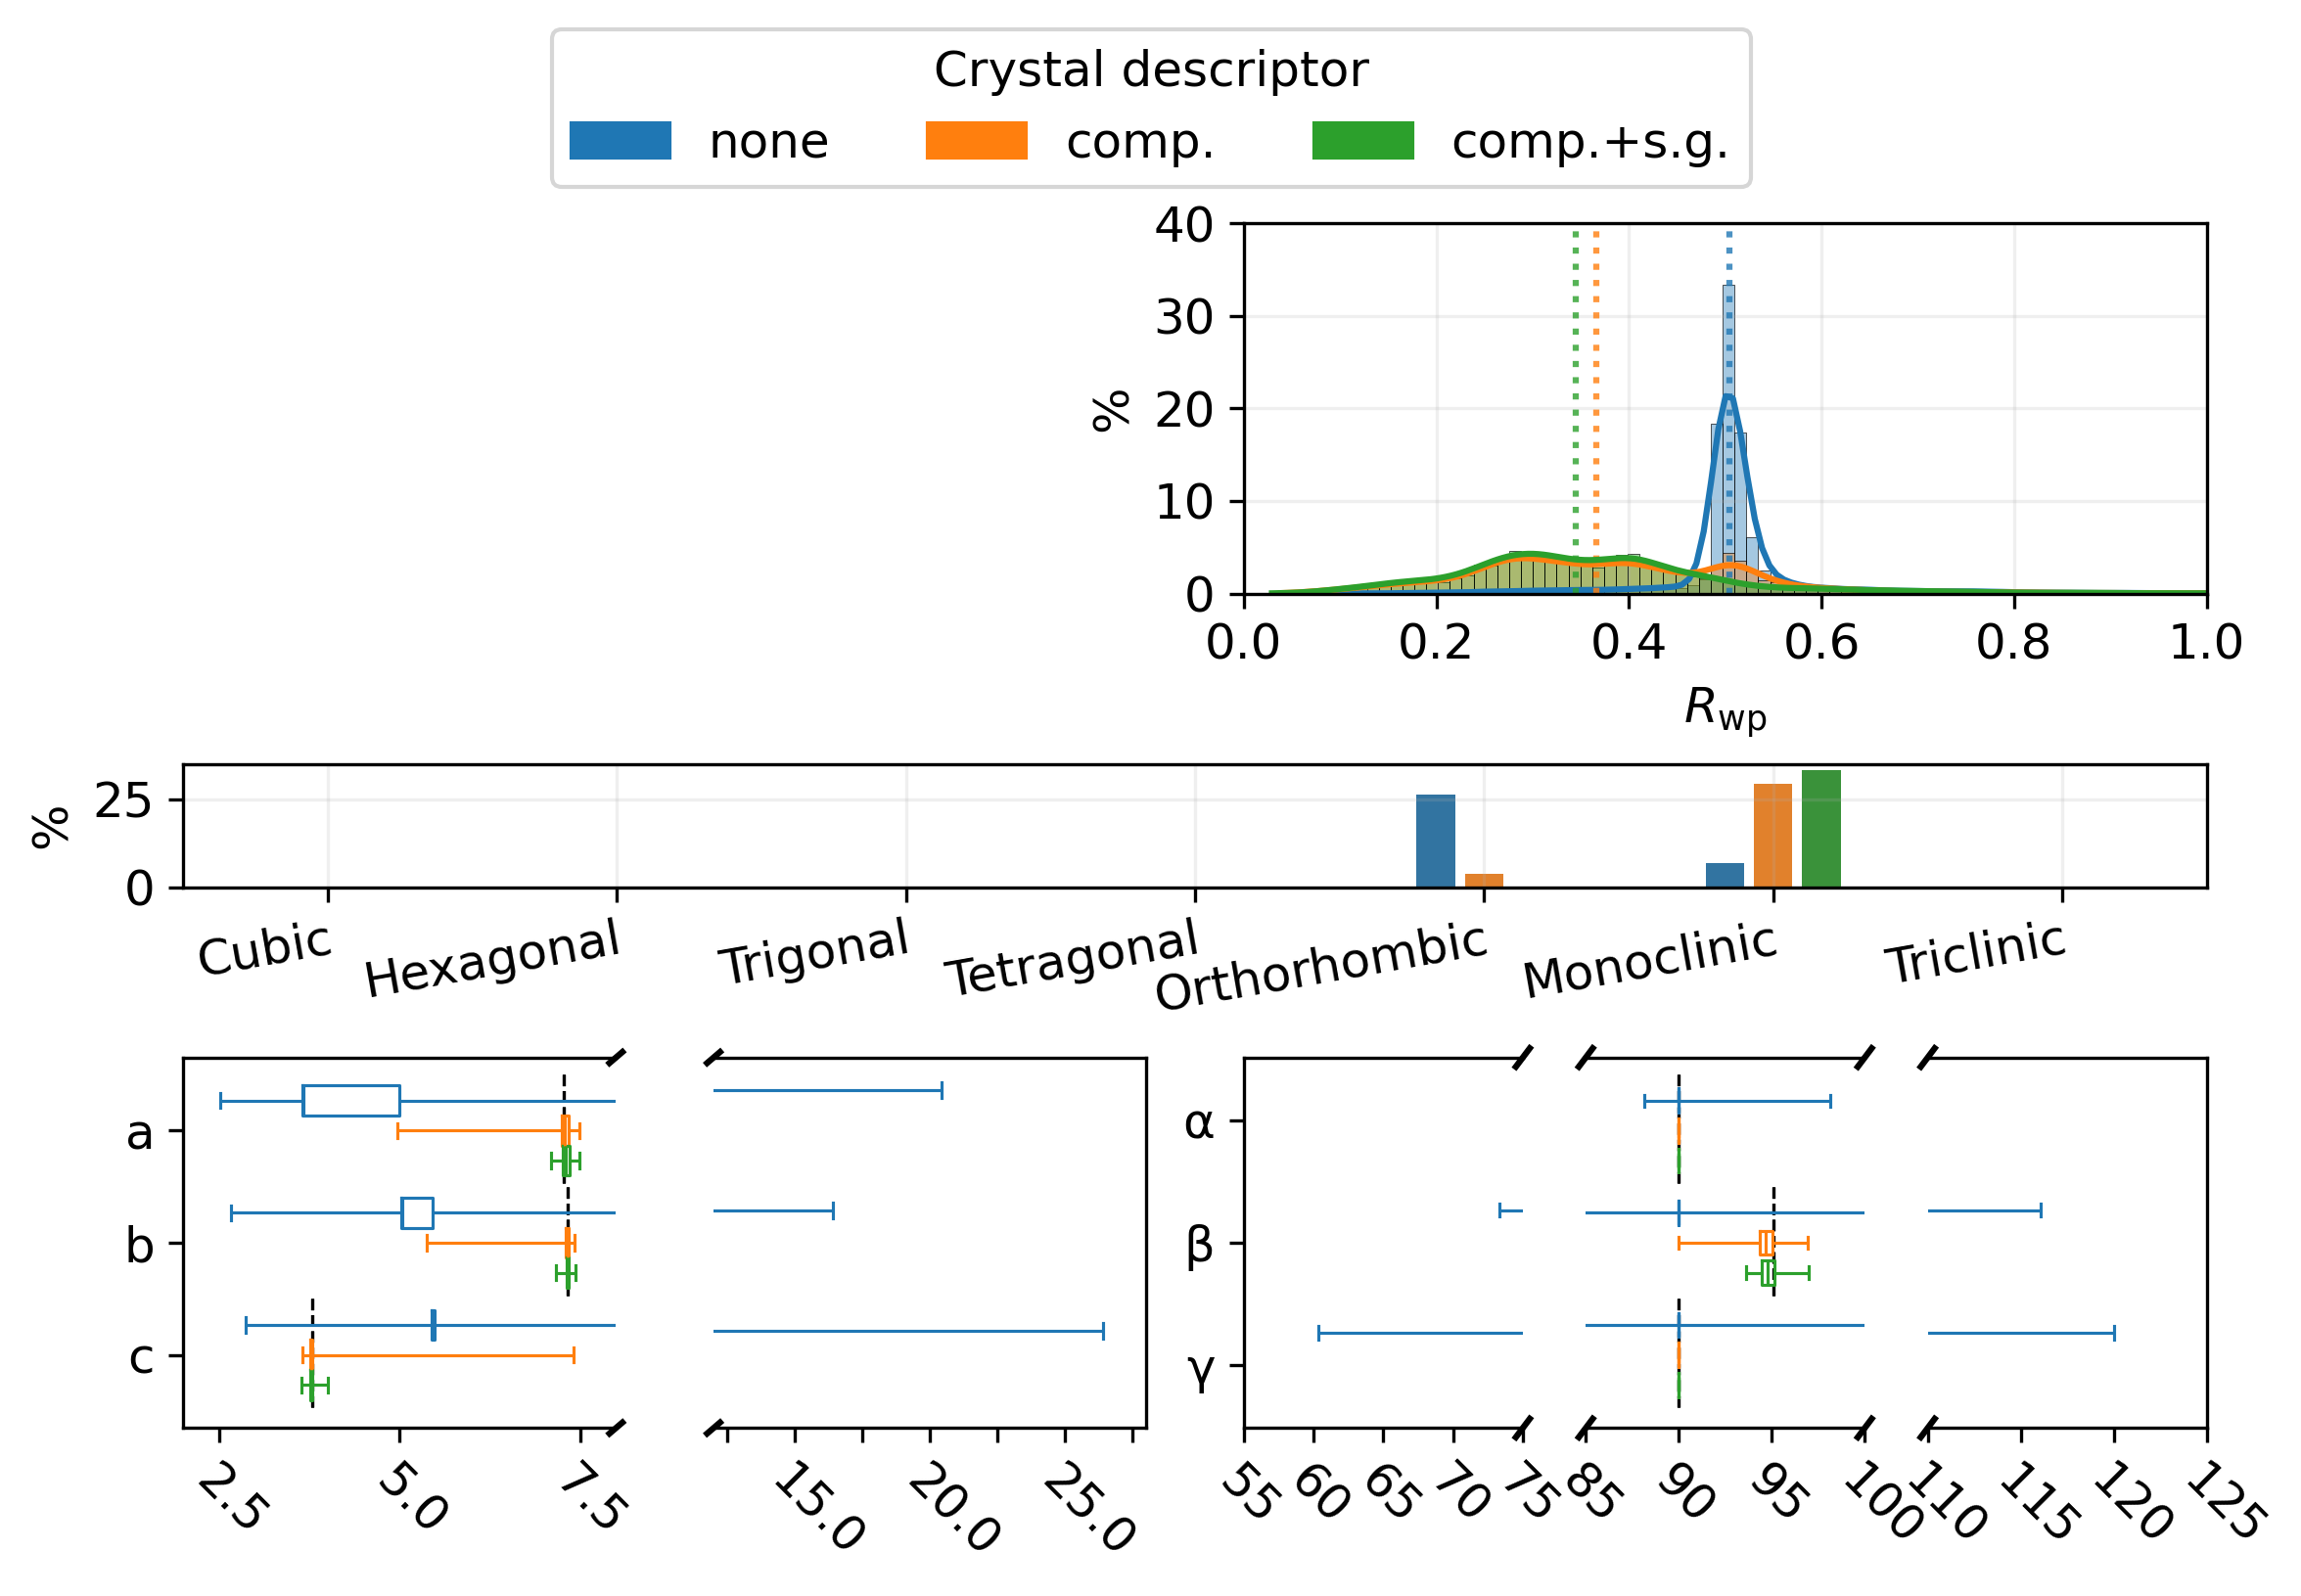

In [7]:
from matplotlib.gridspec import GridSpec
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches

# Assume df_none, df_comp, df_compsg, combined_data_lengths, combined_data_angles are already defined
fsize = 12
plt.rcParams.update({
    "font.size": fsize,
    "axes.titlesize": fsize,
    "axes.labelsize": fsize,
    "xtick.labelsize": fsize,
    "ytick.labelsize": fsize,
    "legend.fontsize": fsize,
    "legend.title_fontsize":fsize,
})

# Set up the figure and GridSpec
fig = plt.figure(figsize=(8, 5), dpi=300)
gs = GridSpec(3, 4, height_ratios=[0.6, 0.2, 0.6])  # Adjust hspace to control spacing

# Plot 1: Histogram (no changes here)
ax1 = fig.add_subplot(gs[0, 2:])
palette = sns.color_palette()

# Function to add median lines
def add_median_line(ax, data, label, color):
    median_value = data['rwp'].median()
    ax.axvline(median_value, color=color, linestyle=':', alpha=0.8)

stat = 'percent'
sns.histplot(
    df_none['rwp'], bins=bins, kde=True, ax=ax1, label='none', alpha=0.4, stat=stat, legend=False,
)
add_median_line(ax1, df_none, 'none', palette[0])

sns.histplot(
    df_comp['rwp'], bins=bins, kde=True, ax=ax1, label='comp.', alpha=0.4, stat=stat, legend=False,
)
add_median_line(ax1, df_comp, 'comp.', palette[1])

sns.histplot(
    df_compsg['rwp'], bins=bins, kde=True, ax=ax1, label='comp.+s.g.', alpha=0.4, stat=stat, legend=False,
)
add_median_line(ax1, df_compsg, 'comp.+s.g.', palette[2])

ax1.set_xlabel("$R_{\mathrm{wp}}$")
ax1.set_ylabel("%")
ax1.grid(alpha=0.2)
y_min = 0
y_max = 40
num_subdivisions = 4
y_subdivisions = np.linspace(y_min, y_max, num_subdivisions + 1)
ax1.set_yticks(y_subdivisions)
ax1.set_xlim(0,1)
# ax1.set_yscale('asinh')

# # Create custom legend with solid colors
# legend_patches = [
#     mpatches.Patch(color=palette[0], label='none'),
#     mpatches.Patch(color=palette[1], label='comp.'),
#     mpatches.Patch(color=palette[2], label='comp.+s.g.')
# ]
# ax1.legend(handles=legend_patches, title='Crystal descriptors')

# Plot 2: Violin plot with broken x-axis for lengths
ax21_left = fig.add_subplot(gs[2, 0])
ax21_right = fig.add_subplot(gs[2, 1])

sns.boxplot(
    y="Parameter", x="Value", hue="Type", data=combined_data_lengths, ax=ax21_left, fill=False,
    dodge=True, legend=False, whis=(0,100), linewidth=.75, fliersize=2.0
)
sns.boxplot(
    y="Parameter", x="Value", hue="Type", data=combined_data_lengths, ax=ax21_right, fill=False,
    dodge=True, legend=False, whis=(0,100), linewidth=.75, fliersize=2.0
)

# Add horizontal lines for `_sample` values and annotate
sample_values = {
    "a_gen": [df_none['a_sample'].iloc[0], df_comp['a_sample'].iloc[0], df_compsg['a_sample'].iloc[0]],
    "b_gen": [df_none['b_sample'].iloc[0], df_comp['b_sample'].iloc[0], df_compsg['b_sample'].iloc[0]],
    "c_gen": [df_none['c_sample'].iloc[0], df_comp['c_sample'].iloc[0], df_compsg['c_sample'].iloc[0]],
}

for i, param in enumerate(["a_gen", "b_gen", "c_gen"]):
    ax21_left.vlines(x=sample_values[param], ymin= i - 0.5, ymax=i + 0.5, colors="black", linestyles="--", lw=.75, zorder=-1)

# Adjust x-limits for broken axis
ax21_left.set_xlim(2, 8)  # Example limits
ax21_right.set_xlim(12, 28)  # Example limits

# Diagonal lines for broken axis
d = .015
kwargs = dict(transform=ax21_left.transAxes, color='k', clip_on=False)
ax21_left.plot((1-d, 1+d), (-d, +d), **kwargs)
ax21_left.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax21_right.transAxes)
ax21_right.plot((-d, +d), (-d, +d), **kwargs)
ax21_right.plot((-d, +d), (1-d, 1+d), **kwargs)

# Add a break marker between the plots
ax21_left.spines['right'].set_visible(False)
ax21_right.spines['left'].set_visible(False)
ax21_left.yaxis.tick_left()
ax21_right.yaxis.tick_right()
ax21_right.tick_params(labelleft=False)  # Remove y-axis labels for the second plot

ax21_left.set_xlabel("")
ax21_left.set_ylabel("")
ax21_left.set_yticks(range(3))
ax21_left.set_yticklabels(['a', 'b', 'c'])
ax21_left.grid(False)

ax21_right.set_xlabel("")
ax21_right.set_ylabel("")
ax21_right.set_yticks([])
ax21_right.grid(False)

# Adjust positions manually
pos_left = ax21_left.get_position()
pos_right = ax21_right.get_position()

# Modify positions: reduce horizontal space
ax21_left.set_position([pos_left.x0, pos_left.y0, pos_left.width * 0.95, pos_left.height])  # Shrink width slightly
ax21_right.set_position([pos_right.x0 - 0.1, pos_right.y0, pos_right.width * 0.95, pos_right.height])  # Shift left

# Set scale
ax21_left.xaxis.set_major_locator(MultipleLocator(2.5))
plt.setp(ax21_left.get_xticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
ax21_right.xaxis.set_major_locator(MultipleLocator(2.5))
plt.setp(ax21_right.get_xticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
plt.setp(ax21_right.get_xticklabels()[1::2], visible=False)

# Plot 3: Violin plot with broken x-axis for angles
gs22 = gs[2,2:].subgridspec(1, 3)
ax22_left = fig.add_subplot(gs22[0, 0])
ax22_middle = fig.add_subplot(gs22[0, 1])
ax22_right = fig.add_subplot(gs22[0, 2])

sns.boxplot(
    y="Parameter", x="Value", hue="Type", data=combined_data_angles, ax=ax22_left, fill=False,
    dodge=True, legend=False, whis=(0,100), linewidth=.75, fliersize=1, gap=.2
)

sns.boxplot(
    y="Parameter", x="Value", hue="Type", data=combined_data_angles, ax=ax22_middle, fill=False,
    dodge=True, legend=False, whis=(0,100), linewidth=.75, fliersize=1, gap=.2
)

sns.boxplot(
    y="Parameter", x="Value", hue="Type", data=combined_data_angles, ax=ax22_right, fill=False,
    dodge=True, legend=False, whis=(0,100), linewidth=.75, fliersize=1, gap=.2
)

# Sample values for horizontal lines
sample_values = {
    "alpha_gen": [df_none['alpha_sample'].iloc[0], df_comp['alpha_sample'].iloc[0], df_compsg['alpha_sample'].iloc[0]],
    "beta_gen": [df_none['beta_sample'].iloc[0], df_comp['beta_sample'].iloc[0], df_compsg['beta_sample'].iloc[0]],
    "gamma_gen": [df_none['gamma_sample'].iloc[0], df_comp['gamma_sample'].iloc[0], df_compsg['gamma_sample'].iloc[0]],
}

for i, param in enumerate(["alpha_gen", "beta_gen", "gamma_gen"]):
    ax22_middle.vlines(x=sample_values[param], ymin=i - 0.5, ymax=i + 0.5, colors="black", linestyles="--", lw=.75, zorder=-1)

# Adjust x-limits for broken axis
ax22_left.set_xlim(55, 75) 
ax22_middle.set_xlim(85, 100)
ax22_right.set_xlim(110, 125) 

# Diagonal lines for broken axis
d = .025
kwargs = dict(transform=ax22_left.transAxes, color='k', clip_on=False)
ax22_left.plot((1-d, 1+d), (-d, +d), **kwargs)
ax22_left.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs = dict(transform=ax22_middle.transAxes,  color='k', clip_on=False)
ax22_middle.plot((1-d, 1+d), (-d, +d), **kwargs)
ax22_middle.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
ax22_middle.plot((-d, +d), (-d, +d), **kwargs)
ax22_middle.plot((-d, +d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax22_right.transAxes,  color='k', clip_on=False)
ax22_right.plot((-d, +d), (-d, +d), **kwargs)
ax22_right.plot((-d, +d), (1-d, 1+d), **kwargs)

ax22_left.spines['right'].set_visible(False)
ax22_right.spines['left'].set_visible(False)
ax22_middle.spines['right'].set_visible(False)
ax22_middle.spines['left'].set_visible(False)
ax22_left.yaxis.tick_left()
ax22_right.yaxis.tick_right()
ax22_right.tick_params(labelleft=False)  # Remove y-axis labels for the second plot
ax22_middle.tick_params(labelleft=False)  # Remove y-axis labels for the second plot

ax22_left.set_xlabel("")
ax22_left.set_ylabel("")
ax22_left.set_yticks(range(3))
ax22_left.set_yticklabels(['α', 'β', 'γ'])
ax22_left.grid(False)
ax22_middle.set_xlabel("")
ax22_middle.set_ylabel("")
ax22_middle.set_yticks([])
ax22_middle.grid(False)
ax22_right.set_xlabel("")
ax22_right.set_ylabel("")
ax22_right.set_yticks([])
ax22_right.grid(False)
ax22_right.grid(False)

# Set scale
every = 5
ax22_left.xaxis.set_major_locator(MultipleLocator(every))
plt.setp(ax22_left.get_xticklabels(), rotation=-45, ha="left", rotation_mode="anchor")

ax22_middle.xaxis.set_major_locator(MultipleLocator(every))
plt.setp(ax22_middle.get_xticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
# plt.setp(ax22_middle.get_xticklabels()[1::2], visible=False)

ax22_right.xaxis.set_major_locator(MultipleLocator(every))
plt.setp(ax22_right.get_xticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
# plt.setp(ax22_right.get_xticklabels()[1::2], visible=False)

# Crystal system
ax3 = fig.add_subplot(gs[1, :])
crystal_system_order = ["Cubic", "Hexagonal", "Trigonal", "Tetragonal", "Orthorhombic", "Monoclinic", "Triclinic"]
crystal_system_labels = {i + 1: name for i, name in enumerate(reversed(crystal_system_order))}

combined_crystal_system = pd.DataFrame({
    "none": df_none['crystal_system_gen'],
    "comp.": df_comp['crystal_system_gen'],
    "comp.+s.g.": df_compsg['crystal_system_gen']
})

melted_crystal_system = combined_crystal_system.melt(var_name="Type", value_name="Crystal System")
melted_crystal_system["Crystal System"] = melted_crystal_system["Crystal System"].map(crystal_system_labels)

# Explicitly set the order to include all categories
sns.countplot(
    x="Crystal System",
    hue="Type",
    data=melted_crystal_system,
    ax=ax3,
    order=crystal_system_order,
    stat='percent',
    legend=False,
    gap=.2,
    width=0.5,
)

ax3.set_xlabel("")
# Rotate the tick labels and set their alignment
plt.setp(ax3.get_xticklabels(), rotation=10, ha="right", rotation_mode="anchor")
ax3.grid(alpha=0.2)
ax3.set_ylabel("%")

fig.tight_layout(h_pad=0.5, w_pad=-3.0)

# Final adjustments
# fig.tight_layout()
handles, labels = ax1.get_legend_handles_labels()
legend_patches = [
    mpatches.Patch(color=palette[0], label='none'),
    mpatches.Patch(color=palette[1], label='comp.'),
    mpatches.Patch(color=palette[2], label='comp.+s.g.')
]
fig.legend(legend_patches, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, title="Crystal descriptor")
fig.savefig('broken_consistency.svg', transparent=True, bbox_inches='tight')
plt.show()


In [33]:
import os
import random

# Function to create a folder if it doesn't exist
def create_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

# Function to save CIF strings to files in a specific folder
def save_cif_to_file(cif_string, folder_name, filename):
    filepath = os.path.join(folder_name, filename)
    with open(filepath, 'w') as file:
        file.write(cif_string)

# Function to extract 9 random rows with rwp > median and save their 'cif_string_gen'
def get_random_rows_and_save(df, folder_name, column='rwp', target_column='cif_string_gen', prefix='random', n=9):
    # Create folder
    create_folder(folder_name)
    
    # Filter rows where 'rwp' is greater than the median
    filtered_rows = df[df[column] > df[column].median()]
    
    # Randomly sample n rows from the filtered rows
    random_rows = filtered_rows.sample(n=min(n, len(filtered_rows)), random_state=42)
    
    # Save the target column values as CIF files
    for i, cif_string in enumerate(random_rows[target_column]):
        filename = f"{prefix}_above_median_{i + 1}.cif"
        save_cif_to_file(cif_string, folder_name, filename)

# Function to get rows with the lowest and median rwp and save their CIF strings
def get_lowest_highest_and_median_rows_and_save(df, folder_name, prefix):
    # Create folder
    create_folder(folder_name)
    
    lowest_row = df.loc[df['rwp'].idxmin()]
    highest_row = df.loc[df['rwp'].idxmax()]
    median_row = df.loc[(df['rwp'] - df['rwp'].median()).abs().idxmin()]
    
    # Save CIF strings to files
    save_cif_to_file(lowest_row['cif_string_gen'], folder_name, f"{prefix}_{lowest_row['rwp']:1.3f}lowest.cif")
    save_cif_to_file(highest_row['cif_string_gen'], folder_name, f"{prefix}_{highest_row['rwp']:1.3f}_highest.cif")
    save_cif_to_file(median_row['cif_string_gen'], folder_name, f"{prefix}_{median_row['rwp']:1.3f}_median.cif")

# Function to get diverse examples based on composition and save their CIFs
def get_diverse_compositions_and_save(df, folder_name, coi, target_column='cif_string_gen', prefix='comp', n=9):
    # Create folder
    create_folder(folder_name)
    
    # Group by the composition column
    grouped = df.groupby(coi)
    
    # Select up to n different groups
    selected_groups = list(grouped)[:n]  # Ensure we don't exceed the available groups
    
    # Save one example from each selected group
    for i, (comp_string, group) in enumerate(selected_groups):
        example_row = group.iloc[0]  # Take the first row from each group
        #print(example_row)
        filename = f"{prefix}_diversity_{i + 1}.cif"
        save_cif_to_file(example_row[target_column], folder_name, filename)

# Define folders for saving CIF files
folders = {
    'none': 'cif_files/none',
    'comp': 'cif_files/comp',
    'compsg': 'cif_files/compsg',
}

# Save random rows with rwps higher than the median
get_random_rows_and_save(df_none, folders['none'], prefix='none')
get_random_rows_and_save(df_comp, folders['comp'], prefix='comp')
get_random_rows_and_save(df_compsg, folders['compsg'], prefix='compsg')

# Save lowest and median rows' CIFs for each DataFrame
get_lowest_highest_and_median_rows_and_save(df_none, folders['none'], prefix='none')
get_lowest_highest_and_median_rows_and_save(df_comp, folders['comp'], prefix='comp')
get_lowest_highest_and_median_rows_and_save(df_compsg, folders['compsg'], prefix='compsg')

coi = 'spacegroup_gen'

# Save diverse examples based on composition
# get_diverse_compositions_and_save(df_none, folders['none'], coi, prefix='none')
get_diverse_compositions_and_save(df_comp, folders['comp'], coi, prefix='comp')
# get_diverse_compositions_and_save(df_compsg, folders['compsg'], coi, prefix='compsg')

In [2]:
from decifer_refactored.utility import (
    generate_continuous_xrd_from_cif
)
import os
import matplotlib.pyplot as plt


df_100_reps = load_and_prepare_dataframe("../generated_examples_100_reps_comp/results.pkl")
df_100_reps_cluster = load_and_prepare_dataframe("../self_consistency_comp_100_reps/results.pkl")

In [3]:
# Function to create a folder if it doesn't exist
def create_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

# Function to save CIF strings to files in a specific folder
def save_cif_to_file(cif_string, folder_name, filename):
    filepath = os.path.join(folder_name, filename)
    with open(filepath, 'w') as file:
        file.write(cif_string)

def plot_and_save_pxrd_comparison(cif_string_sample, cif_string_gen, rwp, folder_name, file_name):
    xrd_sample = generate_continuous_xrd_from_cif(
        cif_string_sample,
        qmin = 1.0,
        qmax = 9.0,
        qstep = 0.01,
        noise_range = None,
        intensity_scale_range=None,
        mask_prob=None,
        fwhm_range=(0.05, 0.05)
    )
    xrd_gen = generate_continuous_xrd_from_cif(
        cif_string_gen,
        qmin = 1.0,
        qmax = 9.0,
        qstep = 0.01,
        noise_range = None,
        intensity_scale_range=None,
        mask_prob=None,
        fwhm_range=(0.05, 0.05)
    )
    fig, ax = plt.subplots(figsize=(5,2), dpi=100)
    ax.plot(xrd_sample['q'], xrd_sample['iq'], label='Reference')
    ax.plot(xrd_gen['q'], xrd_gen['iq'], label='Median')
    ax.plot(xrd_gen['q'], xrd_sample['iq'] - xrd_gen['iq'] - 0.05, label='Difference, $R_{\mathrm{wp}}$'+f'={rwp:1.3f}', c='#d62728')
    ax.set(xlim=(1.0,9.0), ylim=(None,1.6))
    ax.set_yticks([])
    ax.legend(loc='upper right')
    plt.show()
    fig.savefig(os.path.join(folder_name, file_name), transparent=True, bbox_inches='tight', dpi=300)

8.150242965780608
14.095412827127156
nan
None
8.150242965780608
14.095412827127156
nan
None


TypeError: 'NoneType' object is not subscriptable

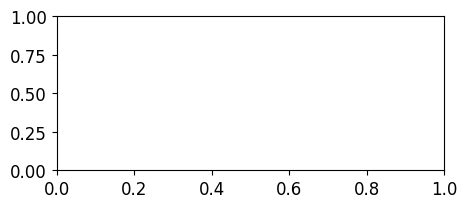

In [4]:
fsize = 12
plt.rcParams.update({
    "font.size": fsize,
    "axes.titlesize": fsize,
    "axes.labelsize": fsize,
    "xtick.labelsize": fsize,
    "ytick.labelsize": fsize,
    "legend.fontsize": 10,
    "legend.title_fontsize":fsize,
})

rel_df = df_100_reps_cluster
folder_name = '100_reps_cifs_cluster'
for name in rel_df['cif_name'].unique():

    if name != 'NOMAD_mw1Nzb7kDazr9nxYQXlT9xcFwiBf':
        continue
    
    df_name = rel_df.loc[rel_df['cif_name'] == name]
    median_df_name = df_name.loc[(df_name['rwp'] - df_name['rwp'].median()).abs().idxmin()]
    
    create_folder(folder_name)
    save_cif_to_file(median_df_name['cif_string_sample'], folder_name, f'{name}_{median_df_name["rwp"]:1.3f}_sample.cif')
    save_cif_to_file(median_df_name['cif_string_gen'], folder_name, f'{name}_{median_df_name["rwp"]:1.3f}_gen.cif')
    plot_and_save_pxrd_comparison(median_df_name['cif_string_sample'], median_df_name['cif_string_gen'],
                                  median_df_name['rwp'], folder_name, f'{name}_{median_df_name["rwp"]:1.3f}_pxrd.png')